### GPUを有効にします

メニューのRuntime -> Change Runtime typeからHardware AcceleratorでGPUを選びます。

### モデルの構築

In [1]:
from keras.applications.vgg16 import VGG16

# モデルの構築とImageNetで学習済みの重みの読み込み
base_model = VGG16(include_top=False, weights='imagenet', pooling=None)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwd

In [2]:
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.models import Model

nb_classes=19

# FC層を構築
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(nb_classes, activation='softmax')(x)
model =  Model(inputs=base_model.input, outputs=predictions)

In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

### データセットの読み込み

In [3]:
# data-content-half.zipをアップロード
from google.colab import files
uploaded = files.upload()

Saving data-content-half.zip to data-content-half.zip


In [4]:
# ファイルの解凍
!unzip intarface-201812-3-data-content.zip

Archive:  data-content-half.zip
   creating: data-content/
   creating: data-content/test/
   creating: data-content/test/burger/
  inflating: data-content/test/burger/IMG_20180718_185022_half.jpg  
  inflating: data-content/test/burger/IMG_20180718_185110_half.jpg  
  inflating: data-content/test/burger/IMG_20180718_185231_half.jpg  
  inflating: data-content/test/burger/P1040719_half.JPG  
  inflating: data-content/test/burger/P1040732_half.JPG  
  inflating: data-content/test/burger/P1040733_half.JPG  
  inflating: data-content/test/burger/P1040740_half.JPG  
  inflating: data-content/test/burger/P1040745_half.JPG  
  inflating: data-content/test/burger/P1040751_half.JPG  
  inflating: data-content/test/burger/P1040758_half.JPG  
   creating: data-content/test/cheese/
  inflating: data-content/test/cheese/IMG_20180718_190513_half.jpg  
  inflating: data-content/test/cheese/IMG_20180718_190619_half.jpg  
  inflating: data-content/test/cheese/P1040485_half.JPG  
  inflating: data-cont

In [3]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# 入力サイズはここで変えます。
im_rows, im_cols = (224, 224)
bs = 32
TRAIN_DIR = "data-content/train"
TEST_DIR = "data-content/test"

# featurewiseの計算の準備のため学習データのIterator
train_batchs = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TRAIN_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = "categorical"
)

x_train = np.array([])
x_train.resize((0, im_rows, im_cols, 3))
for i in range(int(train_batchs.samples/bs) + 1):
    imgs, labels = next(train_batchs)
    x_train = np.vstack((x_train, imgs))

# 学習データのGenerator
datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    horizontal_flip = True,
    vertical_flip = True,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zca_whitening = False,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
#    shear_range = 0.1,
#    zoom_range = 0.1,
    rotation_range = 20,
)
datagen.fit(x_train)

# 学習データのIterator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = True,
    class_mode = "categorical",
)

# featurewiseの計算の準備のためテストデータのIterator
test_batchs = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(
    TEST_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = "categorical"
)

x_test = np.array([])
x_test.resize((0, im_rows, im_cols, 3))
for i in range(int(test_batchs.samples/bs) + 1):
    imgs, labels = next(test_batchs)
    x_test = np.vstack((x_test, imgs))

# テストデータのGenerator
test_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    featurewise_center = True,
    featurewise_std_normalization = True,
    zca_whitening = False
)

test_datagen.fit(x_test)

# テストデータのIterator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (im_rows, im_cols),
    batch_size = bs,
    color_mode = 'rgb',
    shuffle = False,
    class_mode = "categorical",
)

Found 760 images belonging to 19 classes.
Found 760 images belonging to 19 classes.
Found 190 images belonging to 19 classes.
Found 190 images belonging to 19 classes.


### 転移学習

In [7]:
# 最後のDense以外を固定する
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

epochs = 4
s_epochs = int(train_generator.samples / bs)

# train the model on the new data for a few epochs
# まずはDenseレイヤを学習する
model.fit_generator(train_generator, steps_per_epoch=s_epochs, epochs=epochs)

Epoch 1/4
23/23 [==============================] - 27s 1s/step - loss: 2.9812
Epoch 2/4
23/23 [==============================] - 23s 1s/step - loss: 2.8240
Epoch 3/4
23/23 [==============================] - 23s 1s/step - loss: 2.7134
Epoch 4/4
23/23 [==============================] - 23s 1s/step - loss: 2.5872


### Fine-tuning

In [0]:
# 全層のうちで8割は固定し、それ以降は学習対象とする
layer_num = len(model.layers)
for layer in model.layers[:int(layer_num * 0.8)]:
   layer.trainable = False
for layer in model.layers[int(layer_num * 0.8):]:
   layer.trainable = True

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [9]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

lr, decay, eps, bs = (0.001, 1e-4, 1e-8, 32)

from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=lr, decay=decay, epsilon=eps), loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 200
s_epochs = int(train_generator.samples / bs)
v_steps = int(test_generator.samples / bs)

fpath = 'umaibar_'+ base_model.name + '_weights.{epoch:03d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.h5'
cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tb_cb = TensorBoard(log_dir="./tensorlog", histogram_freq=0)
es_cb = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=20, min_delta=0.0001)

model.fit_generator(
    train_generator, 
    steps_per_epoch=s_epochs, 
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=v_steps,
    callbacks=[cp_cb, tb_cb, es_cb]
)


Epoch 1/200
23/23 [==============================] - 27s 1s/step - loss: 2.5622 - acc: 0.2124 - val_loss: 2.0901 - val_acc: 0.3625

Epoch 00001: val_loss improved from inf to 2.09007, saving model to umaibar_vgg16_weights.001-2.56-0.21-2.09-0.36.h5
Epoch 2/200
23/23 [==============================] - 26s 1s/step - loss: 1.7474 - acc: 0.4384 - val_loss: 1.6340 - val_acc: 0.4750

Epoch 00002: val_loss improved from 2.09007 to 1.63401, saving model to umaibar_vgg16_weights.002-1.75-0.44-1.63-0.47.h5
Epoch 3/200
23/23 [==============================] - 26s 1s/step - loss: 1.3219 - acc: 0.5692 - val_loss: 1.2339 - val_acc: 0.5938

Epoch 00003: val_loss improved from 1.63401 to 1.23387, saving model to umaibar_vgg16_weights.003-1.32-0.57-1.23-0.59.h5
Epoch 4/200
23/23 [==============================] - 26s 1s/step - loss: 1.1308 - acc: 0.6332 - val_loss: 1.2446 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 1.23387
Epoch 5/200
23/23 [==============================] - 25s 1s/st

### 学習済みモデルの重み読み込み

In [154]:
# 上で出来上がったval_lossが一番小さいモデルの重みファイルの読み込み
BEST_SCORE_WEIGHTS_FILE = 'weights-20180820/umaibar_vgg16_weights.193-0.00-1.00-0.29-0.91.h5'
model.load_weights(BEST_SCORE_WEIGHTS_FILE, by_name=False)

from keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#### テスト結果の評価

In [18]:
score = model.evaluate_generator(test_generator, steps=6) # 1バッチごとに32枚取り出し、6回(step)繰り返すと190枚すべて取り出せる
scores = model.predict_generator(test_generator, steps=6)

In [19]:
# 日本語を図に入れたい場合はフォントをインストールする必要があります
#target_classes = ['テリヤキバーガー', 'チーズ', 'チキンカレー', 'チョコレート', 'コンポタージュ', 'エビマヨネーズ', 
#           'レモンスカッシュ', 'めんたい', 'なっとう', 'プレミアムチーズ', 'プレミアム明太子', 'プレミアムステーキ', 
#           'シュガーラスク', 'やさいサラダ', 'サラミ', 'たこ焼き', '牛タン塩', 'とんかつソース', 'やきとり']
target_classes = ['burger', 'cheese', 'chicken_curry', 'chocolate', 'corn', 'ebimayo', 'lemon', 'mentai', 'natto',
                 'premium_cheese', 'premium_mentai', 'premium_steak', 'rusk', 'salad', 'salami', 'takoyaki', 'tongue', 'tonkatsu',
                 'yakitori']

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_preds = np.argmax(scores, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_preds)
print(cm)
print('Classification Report')

print(classification_report(test_generator.classes, y_preds, target_names=target_classes))

Confusion Matrix
[[10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  6  3  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  8  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  9  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  9  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0  0  0  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  2  0  8  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  9  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  2  0 

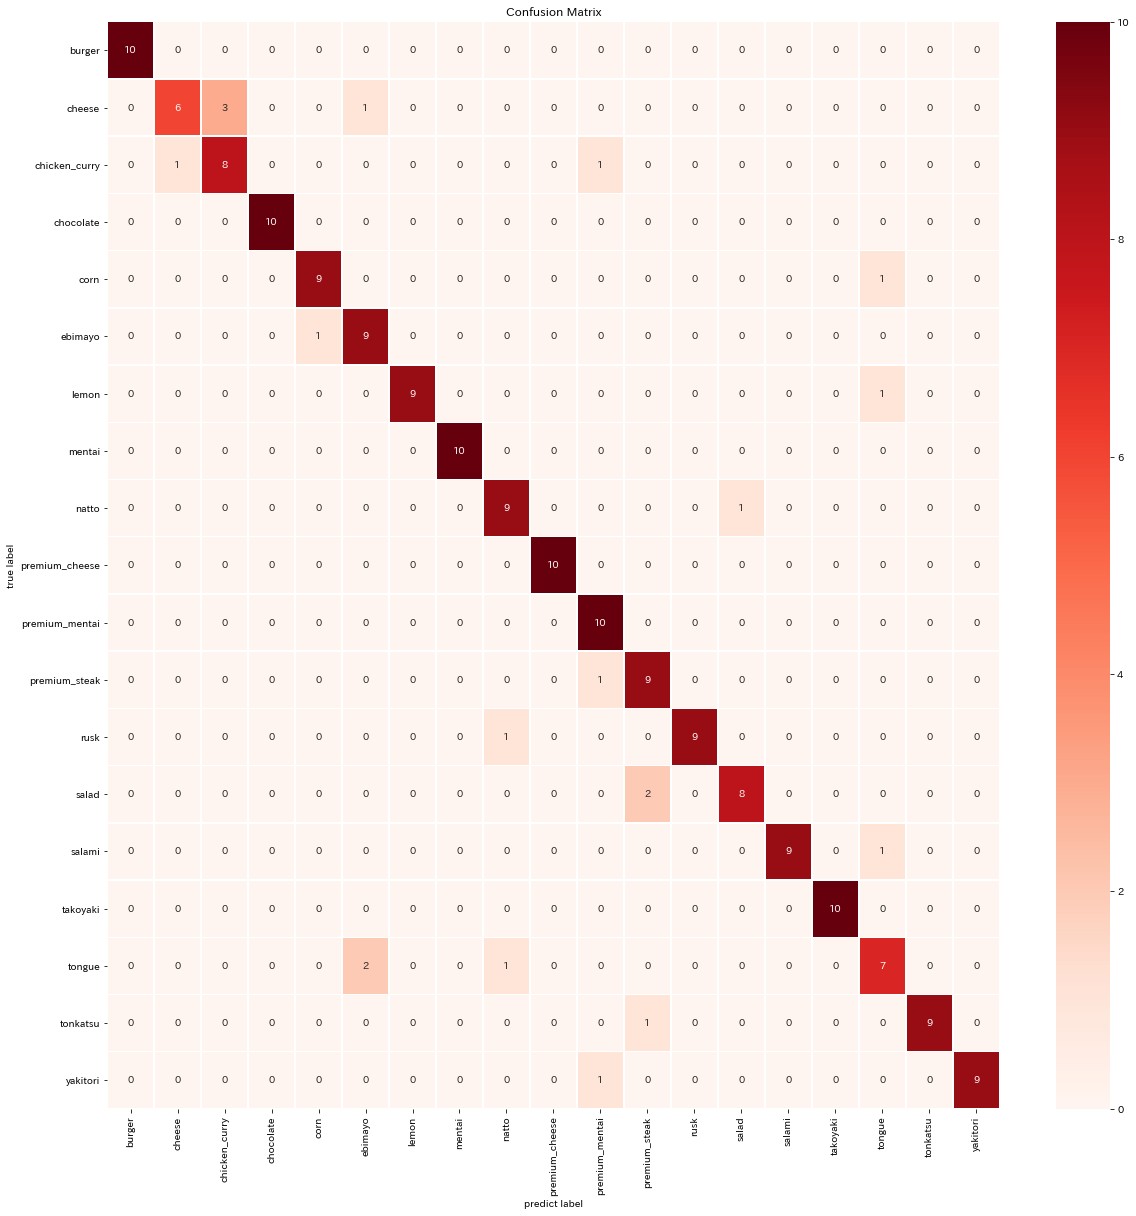

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(20,20))
ax= plt.subplot()
df = pd.DataFrame(data=cm, columns=target_classes, index=target_classes)
sns.heatmap(df, annot=True, ax = ax, linewidths=.5, fmt="d", cmap='Reds'); #annot=True to annotate cells

# labels, title and ticks
#ax.set_xlabel('予測結果')
#ax.set_ylabel('正解ラベル')
ax.set_xlabel('predict label')
ax.set_ylabel('true label')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(target_classes, rotation='vertical')
ax.yaxis.set_ticklabels(target_classes, rotation='horizontal')
plt.show()

In [0]:
import csv

with open('umaibo_predict' + base_model.name + '.csv', 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(['filename'] + target_classes)

    for i, file in enumerate(test_generator.filenames):
        if i < len(scores):
            writer.writerow([file]+[str(x) for x in scores[i]])


In [0]:
print("Loss: ", score[0], "Accuracy: ", score[1])

Loss:  0.4133146838137978 Accuracy:  0.8894736810734397


In [0]:
import pandas as pd

df = pd.read_csv('umaibo_predict' + base_model.name + '.csv', names=target_classes)
df

,burger,cheese,chicken_curry,chocolate,corn,ebimayo,lemon,mentai,natto,premium_cheese,premium_mentai,premium_steak,rusk,salad,salami,takoyaki,tongue,tonkatsu,yakitori
filename,burger,cheese,chicken_curry,chocolate,corn,ebimayo,lemon,mentai,natto,premium_cheese,premium_mentai,premium_steak,rusk,salad,salami,takoyaki,tongue,tonkatsu,yakitori
burger/IMG_20180718_185022_half.jpg,0.9984035,1.0963512e-16,7.2497275e-10,2.2059061e-11,4.7958126e-20,5.3527898e-09,8.116537e-14,4.614377e-12,1.2913e-07,3.5571337e-09,4.8679512e-14,0.0003673052,2.2709409e-16,1.6491415e-10,4.3858242e-10,1.9587525e-09,6.4088626e-15,0.0012290202,4.6384148e-08
burger/IMG_20180718_185110_half.jpg,0.83395207,8.1847695e-17,8.486266e-11,2.2103656e-11,7.348348e-17,5.6952015e-08,1.07541946e-14,4.4769317e-11,3.550828e-05,1.3755568e-09,1.1067872e-08,0.16434759,8.7673485e-18,1.7156755e-07,1.0570636e-07,5.136719e-06,4.337087e-12,0.0016580212,1.3502762e-06
burger/IMG_20180718_185231_half.jpg,0.9997241,2.7147682e-13,1.7674469e-09,1.49003885e-08,1.0427185e-14,6.029475e-06,1.1208324e-11,1.8385111e-11,0.00018647083,5.593289e-08,6.179774e-12,4.2874304e-05,6.157674e-13,6.3464704e-08,2.0784234e-06,1.0780889e-08,2.5956481e-09,3.7986152e-05,2.4655225e-07
burger/P1040719_half.JPG,0.99999964,3.1915025e-22,1.1369826e-18,1.3884117e-12,1.4451035e-26,5.00439e-10,6.01128e-19,3.16472e-23,1.5070436e-08,2.0834808e-13,7.54585e-26,2.6809752e-12,9.3938934e-20,3.292744e-14,1.210144e-13,6.3914216e-16,1.5543779e-20,3.109e-07,1.0777483e-16
burger/P1040732_half.JPG,0.9999993,4.27007e-20,1.4896421e-15,3.0313198e-12,4.730632e-27,5.57397e-09,4.189645e-16,6.4519553e-22,2.445213e-07,1.4245615e-11,2.2415368e-24,6.386122e-11,2.1536074e-19,1.5091793e-13,2.1556832e-15,2.5430669e-17,8.626041e-20,5.016567e-07,3.6105937e-18
burger/P1040733_half.JPG,1.0,3.2987974e-22,3.046114e-19,3.207475e-10,1.1162554e-26,6.578412e-14,1.0770114e-19,3.9321359e-22,2.4286809e-11,1.5780232e-15,5.1941087e-24,2.373097e-13,1.8168032e-26,9.441284e-12,1.3588357e-13,4.2540205e-15,4.9587053e-19,8.4082026e-11,3.4666534e-17
burger/P1040740_half.JPG,0.9999988,4.799515e-22,2.20318e-20,7.889362e-17,3.2203845e-23,1.2698214e-09,1.0689952e-20,2.1521449e-26,1.1490588e-06,4.371874e-15,5.804578e-22,3.0231904e-11,3.5549027e-24,2.9638048e-08,5.365846e-12,1.3441453e-18,2.0092946e-14,4.560784e-12,5.666216e-17
burger/P1040745_half.JPG,0.9999411,2.3038014e-19,2.0630002e-15,1.2377792e-10,2.7573663e-24,4.9387424e-08,7.226024e-17,9.17566e-16,3.5847173e-05,2.1688394e-13,2.2196637e-19,2.8158078e-09,4.214687e-20,1.0303732e-07,2.740891e-13,2.4400363e-13,5.9140545e-13,2.2899738e-05,5.294925e-10
burger/P1040751_half.JPG,1.0,3.999854e-36,1.4323669e-32,2.0160144e-22,2.5659437e-36,1.20103606e-17,4.32205e-30,0.0,2.7283823e-13,1.4301974e-27,3.7343054e-38,7.218011e-19,1.0377038e-37,1.9561047e-16,3.620154e-14,1.3418667e-26,4.7738896e-27,1.2187454e-16,3.5201271e-34


### Grad-CAM

[参考にしたコード](https://github.com/jacobgil/keras-grad-cam/blob/master/grad-cam.py)

In [5]:
import keras.backend as K
import cv2

def grad_cam(model, image, x, layer_name):
    # predict target image
    predictions = model.predict(x, batch_size=1, verbose=0)
    class_idx = np.argmax(predictions[0])
    loss = model.output[:, class_idx]

    conv_output = model.get_layer(layer_name).output
    
    grads = K.gradients(loss, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])

    # get gradients
    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # mean and dot
    weights = np.mean(grads_val, axis = (0, 1))
    cam = np.dot(output, weights)

    # create heatmap
    cam = cv2.resize(cam, (im_rows, im_cols), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    heatmap = cam / cam.max()

    cam = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET) # coloring
    cam = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)  # to RGB
    cam = (np.float32(cam) + image) # composite original image
    
    return cam, heatmap, class_idx


In [6]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

TEST_IMG = 'data-content/test/burger/IMG_20180718_185022_half.jpg'
image = img_to_array(load_img(TEST_IMG, target_size=(im_rows, im_cols)))
image = np.expand_dims(image, axis=0)
x = test_datagen.flow(image, batch_size=1, shuffle=False)

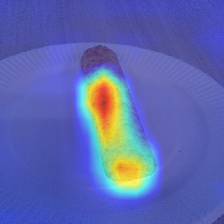

In [7]:
cam, heatmap, predictions = grad_cam(model, image, x.next(), "block5_conv3")
array_to_img(cam[0])

### Guided Grad-CAM

In [8]:
from tensorflow.python.framework import ops
import keras
import tensorflow as tf

def register_gradient():
    if "GuidedBackProp" not in ops._gradient_registry._registry:
        @ops.RegisterGradient("GuidedBackProp")
        def _GuidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * \
                tf.cast(op.inputs[0] > 0., dtype)

def compile_saliency_function(model, activation_layer='block5_conv3'):
    input_img = model.input
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
    layer_output = layer_dict[activation_layer].output
    max_output = K.max(layer_output, axis=3)
    saliency = K.gradients(K.sum(max_output), input_img)[0]
    return K.function([input_img, K.learning_phase()], [saliency])

def modify_backprop(model, name):
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': name}):

        # get layers that have an activation
        layer_dict = [layer for layer in model.layers[1:]
                      if hasattr(layer, 'activation')]

        # replace relu activation
        for layer in layer_dict:
            if layer.activation == keras.activations.relu:
                layer.activation = tf.nn.relu

        # re-instanciate a new model
        base_model = VGG16(include_top=False, weights='imagenet', pooling=None)
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(256, activation='relu')(x)
        predictions = Dense(nb_classes, activation='softmax')(x)
        new_model =  Model(inputs=base_model.input, outputs=predictions)
        
    return new_model

def deprocess_image(x):
    '''
    Same normalization as in:
    https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py
    '''
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


In [11]:
register_gradient()
guided_model = modify_backprop(model, 'GuidedBackProp')

guided_model.load_weights(BEST_SCORE_WEIGHTS_FILE, by_name=False)

guided_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

saliency_fn = compile_saliency_function(guided_model, activation_layer='block5_conv3')

def saliency_process(x):
    return saliency_fn([x])

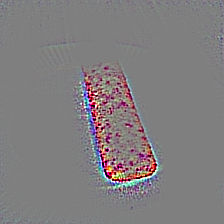

In [13]:
saliency = saliency_process(x.next())
guided = saliency[0] * heatmap[..., np.newaxis]
array_to_img(deprocess_image(guided))

In [0]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras.preprocessing.image import array_to_img, img_to_array

def walk_grad_cam(target_dir, pred_generator, layer_name):
    images = []
    guided_images = []
    for dirpath, dirnames, filenames in os.walk(target_dir):
        for file in sorted(filenames):
            image = img_to_array(load_img(os.path.join(dirpath, file), target_size=(im_rows, im_cols)))
            x = pred_generator.next()[0]  # ImageDataGeneratorの前処理を行いたいため
            cam, heatmap, class_idx = grad_cam(model, image, x, layer_name)
            cam_image = array_to_img(cam)
            cam_image.save(os.path.join(dirpath, os.path.splitext(file)[0] + '_gradcam.jpg'), 'JPEG', quality=100, optimize=True)
            
            saliency = saliency_process(image, x)
            gradcam = saliency[0] * heatmap[..., np.newaxis]
            guided_cam_image = array_to_img(deprocess_image(gradcam))
            guided_cam_image.save(os.path.join(dirpath, os.path.splitext(file)[0] + '_guided.jpg'), 'JPEG', quality=100, optimize=True)

            images.append([class_idx, cam_image, guided_cam_image])

    # 同じフォルダに保存します。次のテスト前に削除する必要があります。
    (d, filename) = os.path.split(target_dir)
    result_images = 'gradcam_'+ filename + '.jpg'
    # 生成した画像を3x3で描画
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0.3)
    for i in range(9):
        img = images[i][1]
        plt.subplot(gs[i])
        plt.imshow(img, aspect='auto')
        plt.title(target_classes[images[i][0]])
        plt.axis("off")
    plt.savefig(result_images)
    plt.close(fig)

    result_images = 'guided_'+ filename + '.jpg'
    # 生成した画像を3x3で描画
    fig = plt.figure()
    gs = gridspec.GridSpec(3, 3)
    gs.update(wspace=0.1, hspace=0.3)
    for i in range(9):
        img = images[i][2]
        plt.subplot(gs[i])
        plt.imshow(img, aspect='auto')
        plt.title(target_classes[images[i][0]])
        plt.axis("off")
    plt.savefig(result_images)
    plt.close(fig)


### テストデータ全てでGrad-CAMおよびGuidedを実行してみる

In [0]:
pred_generator.reset()

# DirectoryIterator, sortedは文字列順でソートする。
for dirpath, dirnames, filenames in os.walk(TEST_DIR):
    for dirname in sorted(dirnames):
        walk_grad_cam(os.path.join(dirpath, dirname), pred_generator, 'block5_conv3')

#### CAM画像を保存

In [0]:
!find data-content -name \*_guided.jpg -print | xargs tar jcf guided-data-content.tar.bz2
!find data-content -name \*_gradcam.jpg -print | xargs tar jcf gradcam-data-content.tar.bz2

#### 同じフォルダに作られたCAM画像を削除

In [0]:
!find data-content -name \*_guided.jpg -print | xargs rm -f
!find data-content -name \*_gradcam.jpg -print | xargs rm -f

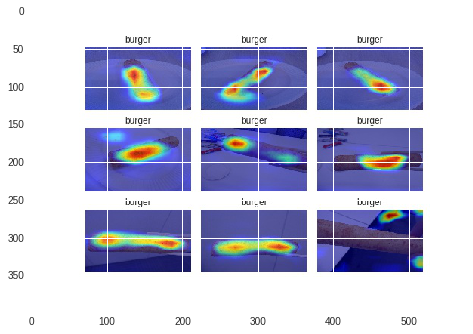

In [0]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
im = Image.open('gradcam_burger.jpg', 'r')
plt.imshow(np.array(im))

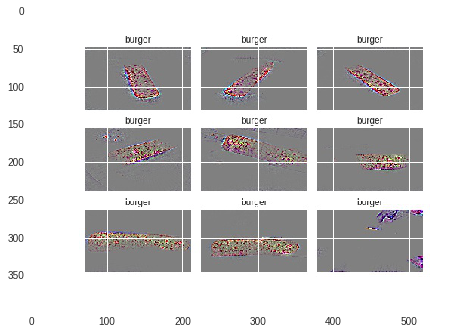

In [0]:
im = Image.open('guided_burger.jpg', 'r')
plt.imshow(np.array(im))

### 特徴埋め込みベクトルの可視化

In [155]:
pred_model = Model(input=model.input,
              output=model.get_layer('block5_pool').output)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("bl...)`



In [101]:
markers = {0: u'tickleft', 1: u'tickright', 2: u'tickup', 4: u'caretleft', u'D': u'diamond', 6: u'caretup', 7: u'caretdown', u's': u'square', u'|': u'vline', u'x': u'x', 5: u'caretright', u'_': u'hline', u'^': u'triangle_up', u'd': u'thin_diamond', u'h': u'hexagon1', u'+': u'plus', u'*': u'star', u',': u'pixel', u'o': u'circle', u'.': u'point', u'1': u'tri_down', u'p': u'pentagon', u'3': u'tri_left', u'2': u'tri_up', u'4': u'tri_right', u'H': u'hexagon2', u'v': u'triangle_down', u'': u'nothing', u'8': u'octagon', u'<': u'triangle_left', u'>': u'triangle_right'}
markers = list(markers.keys())

In [183]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import offsetbox
from sklearn import manifold, datasets
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.colors as colors

def plot_dim_reducer(images, X, labels, algo='tsne'):

    def imscatter(x, y, images, ax=None, zoom=1.0):
        if ax is None:
            ax = plt.gca()
        x, y = np.atleast_1d(x, y)
        artists = []
        for x0, y0, img0 in zip(x, y, images):
            im = OffsetImage(img0, zoom=zoom)
            ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
        ax.update_datalim(np.column_stack([x, y]))
        ax.autoscale()
        return artists

    def plot_embedding(X, imgs, labels=None, title=None):
        x_min, x_max = np.min(X, 0), np.max(X, 0)
        X = (X - x_min) / (x_max - x_min)

        plt.figure(figsize=(10,10),dpi=200)
        plt.grid()
        ax = plt.subplot(111)
        if labels is not None:
#            for i in range(X.shape[0]):
#                plt.text(X[i, 0], X[i, 1], labels[i], fontdict={'weight': 'bold', 'size': 9})
            label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
            id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}
            label_ids = np.array([label_to_id_dict[x] for x in labels])
            nb_classes = len(np.unique(label_ids))
            my_cmap   = plt.get_cmap('jet')
            cNorm     = colors.Normalize(vmin=0, vmax=nb_classes)
            scalarMap = plt.cm.ScalarMappable(norm=cNorm, cmap=my_cmap)
            for label_id in np.unique(label_ids):
                colorVal = scalarMap.to_rgba(label_id)
                plt.scatter(
                    X[np.where(label_ids == label_id),0], 
                    X[np.where(label_ids == label_id),1], 
                    color=colorVal,
                    linewidth='1',
                    alpha=0.8,
                    marker=markers[label_id], 
                    label=id_to_label_dict[label_id])
            plt.legend(loc='best')
        elif hasattr(offsetbox, 'AnnotationBbox'):
            imscatter(X[:,0], X[:,1], imgs, zoom=0.1, ax=ax)

        if title is not None:
            plt.title(title)
        plt.show()

    if algo.lower() == 'tsne':
        print("Computing t-SNE embedding")
        dim_reducer = manifold.TSNE(n_components=2, init='pca', random_state=0)
        X_tsne = dim_reducer.fit_transform(X)
        plot_embedding(X_tsne, images, labels, "t-SNE embedding of images")
    elif algo.lower() == 'pca':
        print("Computing PCA embedding")
        dim_reducer = PCA(n_components=2)
        X_pca = dim_reducer.fit_transform(X)
        plot_embedding(X_pca, images, labels, "PCA embedding of images")

#    plt.savefig(filename, bbox_inches='tight')

In [156]:
from keras.preprocessing.image import load_img, img_to_array
#from imagenet_utils import preprocess_input
import os
import numpy as np

path = 'data-content/test'
X, imgs, labels = [], [], []
for dp, dn, fs in os.walk(path):
    for f in fs:
        if f.endswith(('.jpg', '.JPG', '.png', '.PNG', )):
            filename_full = os.path.join(dp, f)
            labels.append(filename_full.split('/')[-2])
            img = load_img(filename_full, target_size=(224, 224))  # load
            imgs.append(np.array(img))

            # Pre-process for model input
            img = img_to_array(img)  # convert to array
            img = np.expand_dims(img, axis=0)
            x = test_datagen.flow(img, batch_size=1, shuffle=False)
            features = pred_model.predict(x.next()).flatten()  # features
            X.append(features)

X = np.array(X)
imgs = np.array(imgs)

print(imgs.shape)

(190, 224, 224, 3)


Computing t-SNE embedding


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



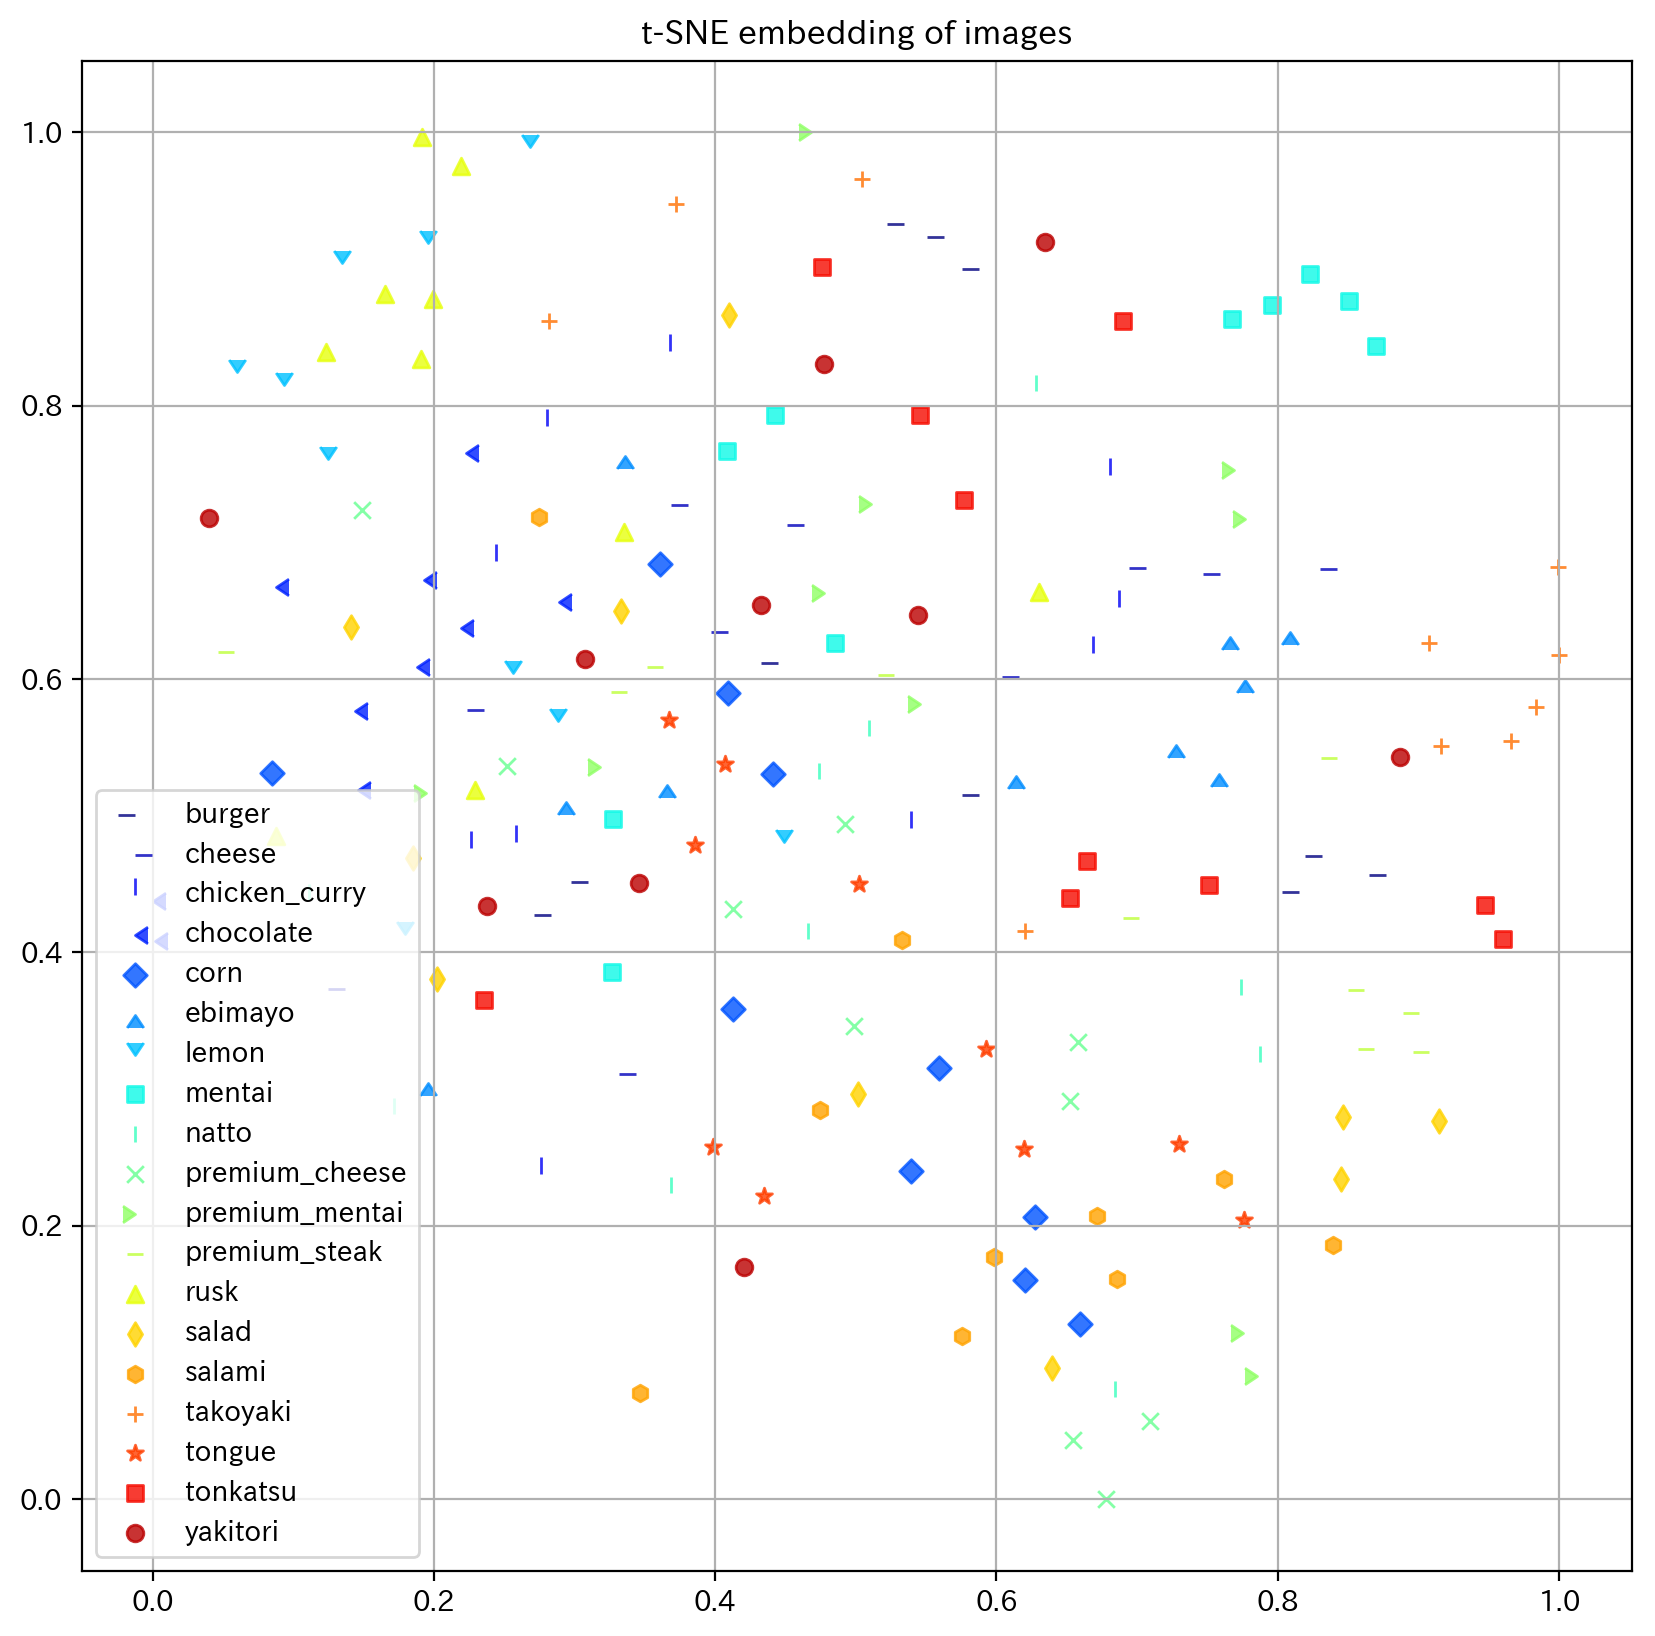

In [157]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_dim_reducer(imgs, X, labels)

Computing t-SNE embedding


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



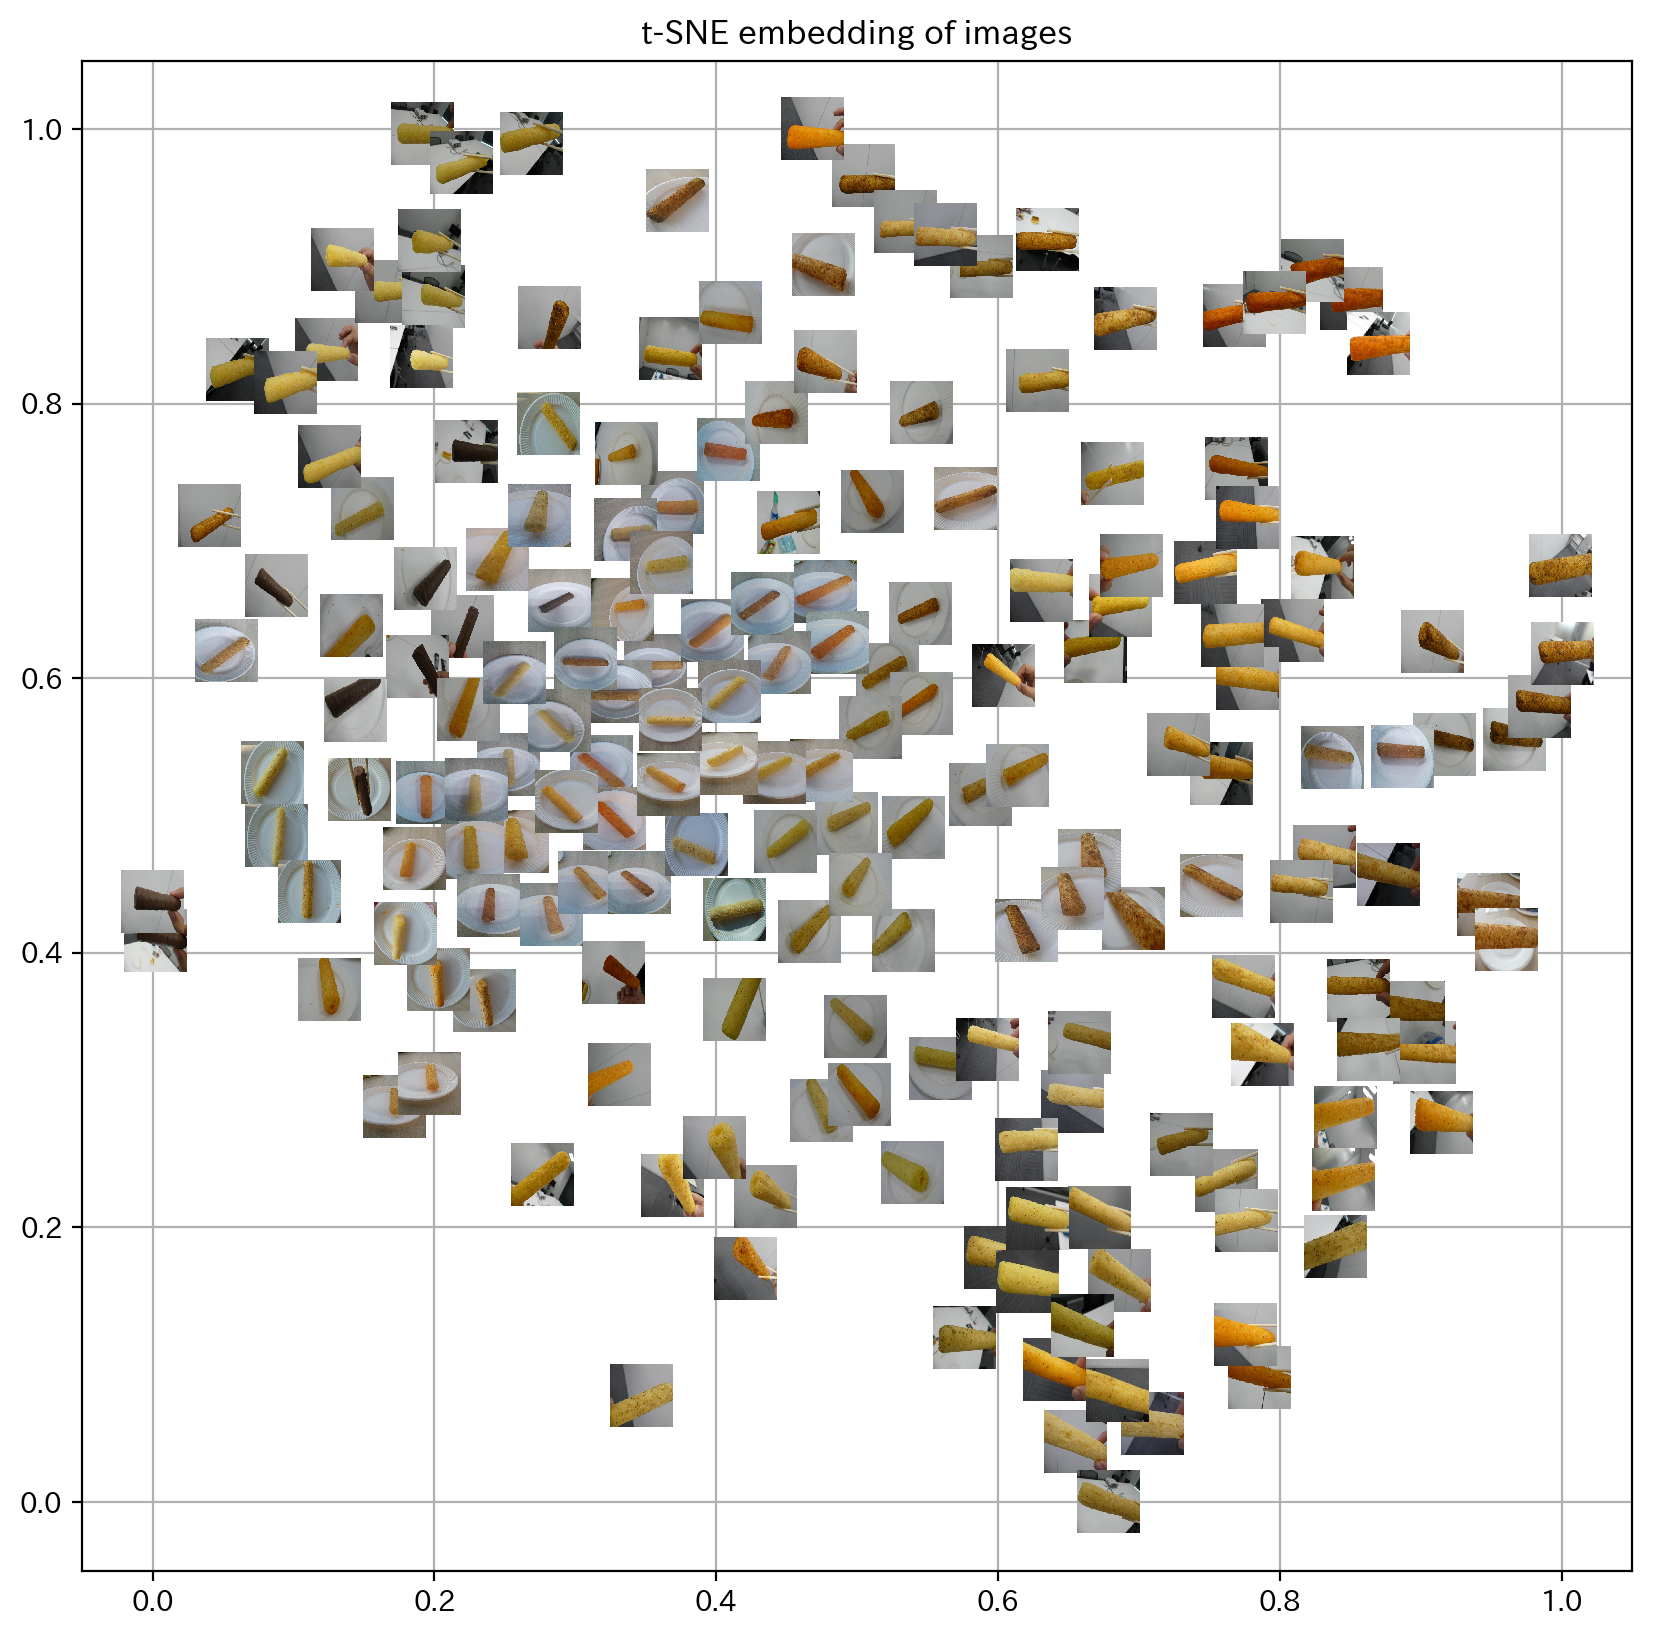

In [162]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_dim_reducer(imgs, X, None, algo='tsne')